# VQ-VAE: Vector Quantised Variational AutoEncoder

Introduced in [Neural Discrete Representation Learning](https://arxiv.org/pdf/1711.00937).

[Video explanation](https://www.youtube.com/watch?v=VZFVUrYcig0&t=1393s)

## __Section 3: VQ-VAE__ 

Perhaps the work most related to our approach are VAEs. VAEs consist of the following parts:
an encoder network which parameterises a posterior distribution $q(z|x)$ of discrete latent random
variables $z$ given the input data $x$, a prior distribution $p(z)$, and a decoder with a distribution $p(x|z)$
over input data.

...

In this work we introduce the VQ-VAE where we use discrete latent variables with a new way of training, inspired by vector quantization (VQ). The posterior and prior distributions are categorical, and the samples drawn from these distributions index an embedding table. These embeddings are used as input into the decoder network.

### __3.1. Discrete Latent Variables__

We define a latent embedding space $e ∈ R^{K×D} $ where $K$ is the size of the discrete latent space (i.e.,
a K-way categorical), and $D$ is the dimensionality of each latent embedding vector $e_i$. Note that
there are $K$ embedding vectors $e_i ∈ R^D , i ∈ 1, 2, ..., K. $ As shown in Figure 1, the model takes an
input $x$, that is passed through an encoder producing output $z_e(x)$. The discrete latent variables $z$
are then calculated by a nearest neighbour look-up using the shared embedding space $e$ as shown in
equation 1. The input to the decoder is the corresponding embedding vector $e_k$ as given in equation 2.
One can see this forward computation pipeline as a regular autoencoder with a particular non-linearity
that maps the latents to 1-of-K embedding vectors. The complete set of parameters for the model are
union of parameters of the encoder, decoder, and the embedding space $e$. 

The posterior categorical distribution $q(z|x)$ probabilities are defined as one-hot as follows:

$ q(z = k|x) = 1 $ for $ k = argmin_j ‖ze(x) − e_j ‖_2 $ and $ 0 $ otherwise

where $ze(x)$  is the output of the encoder network.

### __3.2 Learning__

Since there is no real gradient for equation 2, it is aproximated using the straight-through gradients technique. During forward computation the nearest embedding $z_q(x)$ (equation 2) is passed to the decoder, and during the backwards pass the gradient $∇_zL$ is passed unaltered to the encoder. Since the output representation of the encoder and the input to the decoder share the same $D$ dimensional space, the gradients contain useful information for how the encoder has to change its output to lower the reconstruction loss.

The overall loss function has three components:

1. Reconstruction loss.
2. To learn the embedding space, the VQ objective uses the $l_2$ error to move the embedding vectors $e_i$ towards the encoder outputs $z_e(x)$.
3. Finally, since the volume of the embedding space is dimensionless, it can grow arbitrarily if the embeddings $e_i$ do not train as fast as the encoder parameters. To make sure the encoder commits to an embedding and its output does not grow, we add a commitment loss.

$ L = log p(x|z_q (x)) + ‖sg[z_e(x)] − e‖^2_2 + β‖z_e(x) − sg[e]‖^2_2 $

The decoder optimises the first loss term only, the encoder optimises the first and the last loss terms, and the embeddings are optimised by the middle loss term.

### __3.3 Prior__
The prior distribution over the discrete latents $p(z)$ is a categorical distribution, and can be made autoregressive by depending on other $z$ in the feature map. Whilst training the VQ-VAE the priro is kept constant and uniform. After training, we fit an autoregressive distribution over $z$, $p(z)$, so that we can generate $x$ via ancestral sampling. Training the prior and the VQ-VAE jointly, which could strengthen our results, is left as future research.

# __0. Utils__

## VQ-VAE MODEL

In [3]:
import torch
import torch.nn as nn

In [4]:
def get_encoder(latent_dim=16):
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=latent_dim, kernel_size=1, stride=1, padding=0)
    )

def get_decoder(latent_dim=16):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels=latent_dim, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0)
    )

class VQVAE(nn.Module):

    def __init__(self, vq_layer):
        super().__init__()
        self.emb_dim = vq_layer.emb_dim        
        self.encoder = get_encoder(latent_dim=self.emb_dim)
        self.vq = vq_layer
        self.decoder = get_decoder(latent_dim=self.emb_dim)

    def forward(self, x):
        x  = self.encoder(x)
        quantized, vq_loss, code_idxs = self.vq(x)
        x = self.decoder(quantized)
        return x, vq_loss, code_idxs

## Visualization

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def show(x):
    plt.imshow((x.squeeze(0) + 0.5).detach().cpu().numpy())
    plt.axis('off')
    plt.show()

def show_subplot(original, reconstructed, code_idxs):
    plt.subplot(1,3,1)
    plt.imshow((original.squeeze(0) + 0.5).detach().cpu().numpy())
    plt.axis('off')
    plt.title('Original')

    plt.subplot(1,3,2)
    plt.imshow((reconstructed.squeeze(0) + 0.5).detach().cpu().numpy())
    plt.axis('off')
    plt.title('Reconstructed')

    plt.subplot(1,3,3)
    plt.imshow((code_idxs).detach().cpu().numpy())
    plt.axis('off')
    plt.title('Code Idxs')
    
    plt.show()

def plot_codebook(codebook, usage, point_size_min=0.5, point_size_max=5):
    usage = (usage - usage.min()) / ((usage.max() - usage.min()) + 1e-6)
    point_sizes = usage * (point_size_max - point_size_min) + point_size_min
    plt.scatter(codebook[:, 0], codebook[:, 1], s=point_sizes)

def plot_codebook_usage(usage):
    codebook_size = usage.shape[0] 
    dim = int(np.sqrt(codebook_size))
    usage = usage.reshape(dim, dim)
    zero_usage_msk = usage == 0
    
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(usage, cmap='gray')

    ax[1].imshow(zero_usage_msk, cmap='gray')
    ax[1].set_title('white = Unused codeword')

    print(f"Codebook usage stats: {zero_usage_msk.sum()} tokens ({(zero_usage_msk.sum() / codebook_size) * 100}%) are never used in this codebook.")

def print_usage_stats(usage, title):
    print(f'min: {usage.min()}')
    print(f'max: {usage.max()}')
    print(f'median: {np.median(usage)}')
    print(f'std: {usage.std()}')
    print(f'max used id: {usage.argmax()}, {usage[usage.argmax()]}')
    print(f'min used id: {usage.argmin()}, {usage[usage.argmin()]}')
    

    plt.plot(np.sort(usage), linewidth=0.4)
    plt.scatter(list(range(len(usage))), np.sort(usage), c='black', s=3)
    plt.title(title)

## Training Setup

In [6]:
import torchvision
import torchvision.transforms as transforms

class Scale(nn.Module):
    def forward(self, x):
        return x - 0.5

tfms = transforms.Compose([transforms.ToTensor(), Scale()])

In [7]:
def train(model, dataset, optimizer, device, epochs, batch_size, data_variance=0.1):
    
    model = model.train()
    model.to(device)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

    for epoch in range(epochs):
        total_epoch_loss = 0
        total_r_loss = 0
        total_vq_loss = 0
        for x, _ in dataloader:
            x = x.to(device)
            optimizer.zero_grad()
            reconstruction, vq_loss, _ = model(x)
            reconstruction_loss = torch.nn.functional.mse_loss(reconstruction, x) / data_variance
            epoch_loss = reconstruction_loss + vq_loss
            epoch_loss.backward()
            optimizer.step()
            total_epoch_loss = total_epoch_loss + (epoch_loss.item() * (x.shape[0] / len(ds_train)))
            total_r_loss = total_r_loss + (reconstruction_loss.item() * (x.shape[0] / len(ds_train)))
            total_vq_loss = total_vq_loss + (vq_loss.item() * (x.shape[0] / len(ds_train)))
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'loss: {total_epoch_loss} - reconstruction loss: {total_r_loss} - vqvae loss: {total_vq_loss}')
    

In [8]:
def test(model, dataset, device):
    BATCH_SIZE_TEST = 10
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE_TEST, shuffle=True)
    model = model.eval()
    model.to(device)
    
    x, y = next(iter(dataloader))
    r, _, idxs = model(x.to(device))
    print(x.shape, r.shape, idxs.shape)
    for original, reconstructed, code_idxs in zip(x,r, idxs):
        show_subplot(original, reconstructed, code_idxs)

## Dataset

In [9]:
ds_train = torchvision.datasets.MNIST("./data", train=True, transform=tfms, download=True)
ds_test = torchvision.datasets.MNIST("./data", train=False, transform=tfms, download=True)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Parameters

In [11]:
params = dict()
params['lr'] = 1e-3
params['batch_size'] = 128
params['epochs'] = 30
params['codebook_size'] = 64
params['emb_dim'] = 2
params

{'lr': 0.001,
 'batch_size': 128,
 'epochs': 30,
 'codebook_size': 64,
 'emb_dim': 2}

# __1. Vanilla Implementation__

In [14]:
class MaxNormLayer(nn.Module):

    def __init__(self, max_norm):
        """
        max_norm (float, optional) – If given, each embedding vector with norm larger than max_norm is renormalized to have norm max_norm.
        """
        super().__init__()
        self.max_norm = max_norm

    def forward(self, x):
        if self.max_norm is not None:
            norm = x.norm(dim=-1, keepdim=True)
            higher_than_max_norm_mask = norm > self.max_norm
            x_normalized = (x / norm) * self.max_norm
            x = torch.where(higher_than_max_norm_mask, x_normalized, x)
        return x    

class VectorQuantizerLayer(nn.Module):

    def __init__(self, codebook_size, emb_dim, beta=0.25, decay=0.99):
        super().__init__()
        self.codebook_size = codebook_size
        self.emb_dim = emb_dim
        self.beta = beta
        self.decay = decay
        # EMA codebook usage
        self.register_buffer('codebook_usage', torch.zeros((codebook_size)))
        self.max_norm_layer = MaxNormLayer(max_norm=1)
        # Codebook
        codebook_init = self.max_norm_layer(torch.normal(mean=0.0, std=0.6, size=(self.codebook_size, self.emb_dim)))
        self.codebook = nn.Parameter(codebook_init, requires_grad=False)

    def ema_codebook_usage_update(self, code_idxs_one_hot):
        codeword_cluster_size = code_idxs_one_hot.sum(dim=0)
        weighted_codeword_cluster_size = codeword_cluster_size / codeword_cluster_size.sum() # weight n_counts by batch_size
        self.codebook_usage = self.codebook_usage  * self.decay + (1-self.decay) * weighted_codeword_cluster_size
    
    def forward(self, x):
        # Input shape from BCHW to BHWC and flatten.
        x = x.permute(0,2,3,1).contiguous()
        x = self.max_norm_layer(x)
        x_flat = x.reshape((-1, self.emb_dim))
        
        # Compute distances
        distances = (torch.sum(x_flat**2, dim=1, keepdim=True) 
                   + torch.sum(self.codebook**2, dim=1)
                   - 2 * torch.matmul(x_flat, self.codebook.T))
        
        # Encode
        code_idxs = torch.argmin(distances, dim=1)
        code_idxs_one_hot = torch.nn.functional.one_hot(code_idxs, self.codebook_size).type(self.codebook.dtype)
        # Quantize
        quantized = code_idxs_one_hot @ self.codebook
        quantized = quantized.view(x.shape)

        # Update codebook statistics usage
        self.ema_codebook_usage_update(code_idxs_one_hot)
        
        # Compute loss
        commitment_loss = torch.nn.functional.mse_loss(x, quantized.detach())
        codebook_loss = torch.nn.functional.mse_loss(quantized, x.detach())
        vq_loss = codebook_loss + self.beta * commitment_loss
        # Straight-through estimator
        quantized = x + (quantized - x).detach()
        return quantized.permute(0,3,1,2).contiguous(), vq_loss, code_idxs.view((*x.shape[:-1],1))

## Training

In [15]:
params

{'lr': 0.001,
 'batch_size': 128,
 'epochs': 30,
 'codebook_size': 64,
 'emb_dim': 2}

In [16]:
vq_layer = VectorQuantizerLayer(codebook_size=params['codebook_size'], emb_dim=params['emb_dim'])
model = VQVAE(vq_layer=vq_layer)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

In [17]:
train(model=model,
      dataset=ds_train,
      optimizer=optimizer,
      device=device,
      epochs=params['epochs'],
      batch_size=params['batch_size']
     )

Epoch 1/30
loss: 0.16907117915550876 - reconstruction loss: 0.160520038119952 - vqvae loss: 0.008551141255845617
Epoch 2/30
loss: 0.08643930554787321 - reconstruction loss: 0.07891524056990938 - vqvae loss: 0.007524065150568882
Epoch 3/30
loss: 0.07989778635899233 - reconstruction loss: 0.0728115504940351 - vqvae loss: 0.007086235996335744
Epoch 4/30
loss: 0.07723903278907139 - reconstruction loss: 0.07033170417944594 - vqvae loss: 0.0069073288530111365
Epoch 5/30
loss: 0.07577645685672754 - reconstruction loss: 0.06891975802183146 - vqvae loss: 0.006856698831170796
Epoch 6/30
loss: 0.07467242416540777 - reconstruction loss: 0.06782294239203135 - vqvae loss: 0.006849481938779351
Epoch 7/30
loss: 0.07392572913964598 - reconstruction loss: 0.0670661950866381 - vqvae loss: 0.0068595341652631855
Epoch 8/30
loss: 0.07320805943012236 - reconstruction loss: 0.06631761495272326 - vqvae loss: 0.006890444708118834
Epoch 9/30
loss: 0.07276889895598097 - reconstruction loss: 0.06585994828144712 - 

torch.Size([10, 1, 28, 28]) torch.Size([10, 1, 28, 28]) torch.Size([10, 7, 7, 1])


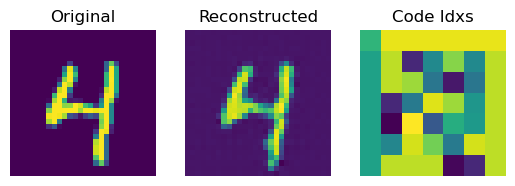

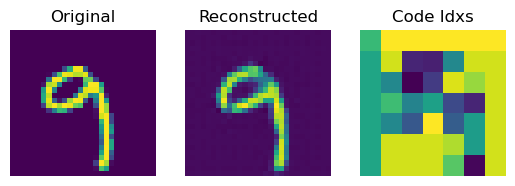

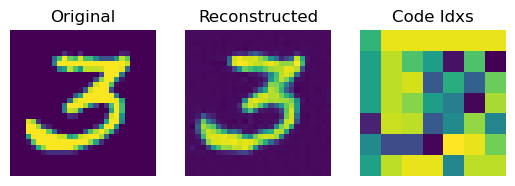

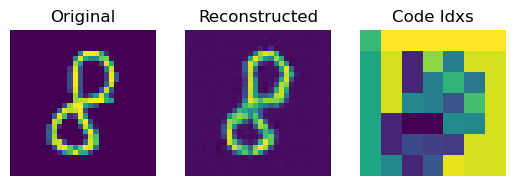

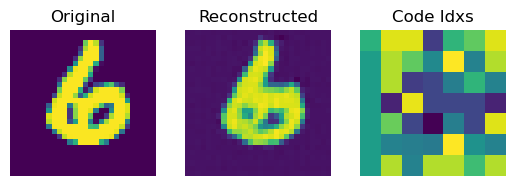

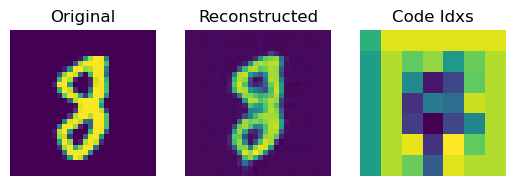

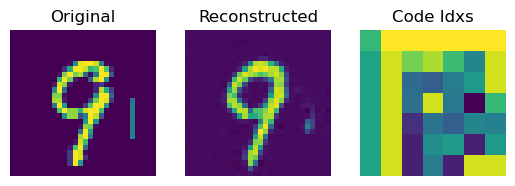

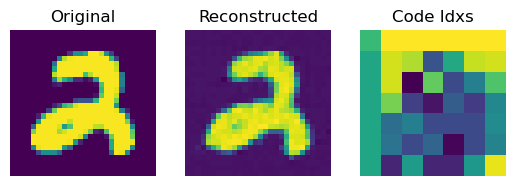

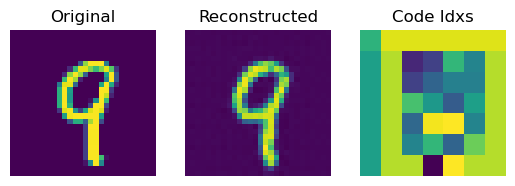

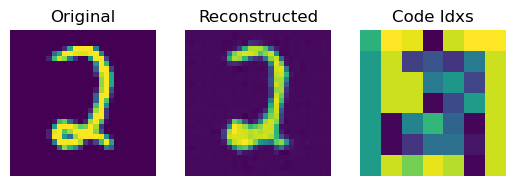

In [31]:
test(model=model, dataset=ds_test, device=device)

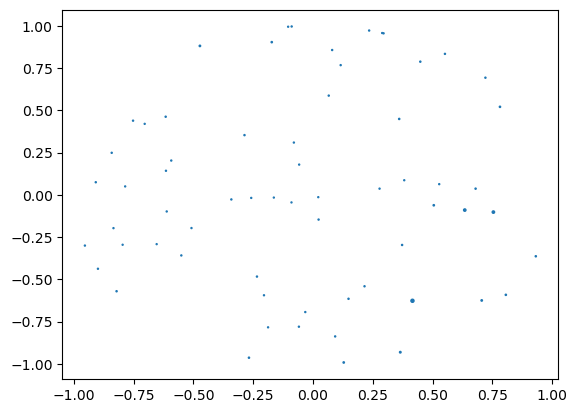

In [24]:
plot_codebook(codebook = model.vq.codebook.data.detach().cpu().numpy(),
              usage = model.vq.codebook_usage.detach().cpu().numpy())

Codebook usage stats: 0 tokens (0.0%) are never used in this codebook.


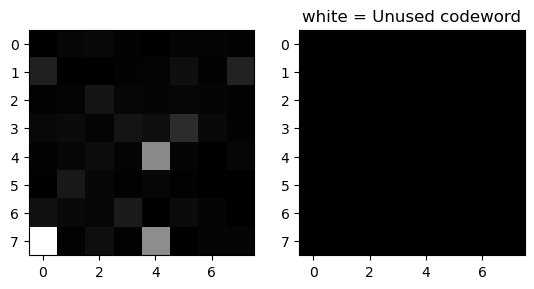

In [25]:
plot_codebook_usage(usage=model.vq.codebook_usage.detach().cpu().numpy())

min: 0.001184483291581273
max: 0.22942252457141876
median: 0.006136028096079826
std: 0.03469602018594742
max used id: 56, 0.22942252457141876
min used id: 38, 0.001184483291581273


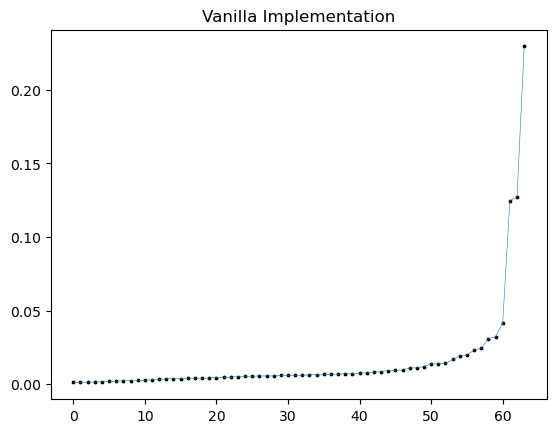

In [26]:
usage = model.vq.codebook_usage.detach().cpu().numpy()
print_usage_stats(usage, title='Vanilla Implementation')

# __2. Flavored Implementation__

## __Towards Efficient World Models__ ([Alonso et al. 2021](https://openreview.net/pdf?id=o8IDoZggqO)):

_"We use vector quantization with factorized and normalized codes ([Yu et al. 2021](https://arxiv.org/pdf/2110.04627)) to discretize te encoder's continuous outputs."_

...

_"The codebook is updated with an exponential moving average ([Razavi et al. 2019](https://arxiv.org/pdf/1906.00446)) and revive unused codewords ([Zeghidour et al. 2021](https://arxiv.org/pdf/2107.03312))."_

### __Vector-Quantized Image Modeling with Improved VQGAN__ ([Yu et al. 2021](https://arxiv.org/pdf/2110.04627)):
Section 3.2 Codebook Learning:
Vanilla VQVAEs suffer from low codebook usage due to the poor initialization of the codebook. Thus, during training a significant portion of codes are rarely used, or dead. 
- ✔️ __Factorized codes.__ We introduce a linear projection from the output of the encoder to a low-dimensional latent variable space for code index lookup and findt it has an immediate boost of codebook usage. The factorization can be viewed as decoupling code lookup and code embedding: we lookup the closest variable encoded from the input on a lower-dimensional lookup space and then project the matched latent code to the high dimensional embedding space.
- ❌ __L2 normalized codes.__ We apply L2 normalization on the encoded latent variables $z_e(x)$ and codebook latent variables $e$. The codebook variables are initialized from a normal distribution. By mapping all latent variables on a sphere, the Euclidean distance of L2-normalized latent variables $||l_2(z_e(x)) - l_2(e_j)||^2_2$ evolves to the cosine similarity of two vectors between $z_e(x)$ and $e$, further improving training stability and reconstruction quality shown in our experiments.

### __VQ-VAE-2 Codebook EMA Updates__ ([Razavi et al. 2019](https://arxiv.org/pdf/1906.00446))
- ✔️ This version __uses exponential moving averages to update the codebook embedding vectors__ instead of an auxiliary loss. This has the advantage that the embedding updates are independent of the choice of optimizer used for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version. [code](https://github.com/google-deepmind/sonnet/blob/v1/sonnet/python/modules/nets/vqvae.py#L124)

### __Revive unused codewords__ ([Zeghidour et al. 2021](https://arxiv.org/pdf/2107.03312))
To improve the usage of codebooks we use two additional methods:
- ❌ __kmeans initialization__: instead of using a random initialization for the codebook vectors, we run the k-means algorithm on the first training batch and use the learned centroids as initialization. This allows the codebook to be close to the distribution of its inputs and improves its usage.
- ❌ __codeword revival__: when a codeword has not been assigned any input frame for several batches, we replace it with an input frame randomly sampled within the current batch. More precisely, we track the exponential moving average of the assignments to each vector (with decay factor of 0.99) and replace the vectors of which this statistic fall below 2.

### __TD-MPC2: Scalable, Robust World Models for Continuous Control__
- ✔️__Normalized task embeddings__ (_Figure 18_): We find that normalizing $e$ to have a maximum $l_2-norm$ of 1 improves multitask performance.

In [33]:
class VectorQuantizerEMALayer(nn.Module):

    def __init__(self, codebook_size, emb_dim, emb_dim_factorized, decay=0.99, beta=0.25):
        super().__init__()
        # Parameters
        self.codebook_size = codebook_size
        self.emb_dim = emb_dim
        self.emb_dim_factorized = emb_dim_factorized
        self.beta = beta
        self.decay = decay
        # EMA codebook usage
        self.register_buffer('codebook_usage', torch.zeros((codebook_size)))
        
        # Factorized codes
        self.pre_quant = nn.Linear(self.emb_dim, self.emb_dim_factorized)
        self.post_quant = nn.Linear(self.emb_dim_factorized, self.emb_dim)
        # L2 normalized codes
        self.max_norm_layer = MaxNormLayer(max_norm=1)
        # Codebook
        codebook_init = self.max_norm_layer (torch.normal(mean=0.0, std=0.6, size=(self.codebook_size, self.emb_dim_factorized)))
        self.codebook = nn.Parameter(codebook_init, requires_grad=False)
    
    def ema_weight_update(self, x_flat, code_idxs_one_hot):
        """
        x_flat: Shape(batch, codebook_emb_dim) raw encoded normalized vector. 
        code_idxs_one_hot: Shape(batch, codebook_size) one hot vector indicating the closest embedding index.
        """
        code_usage_counts = torch.sum(code_idxs_one_hot, dim=0) # cluster size for each embedding index in the codebook.
        unused_codes_mask = (code_usage_counts == 0) # mask for clusters of size 0.
        code_usage_counts = code_usage_counts.masked_fill(unused_codes_mask, 1)
        dw = code_idxs_one_hot.T @ x_flat
        dw = dw / code_usage_counts.unsqueeze(1)
        dw = self.max_norm_layer(dw)
        dw = torch.where(unused_codes_mask[..., None], self.codebook.data, dw)
        new_centers = self.codebook.data * self.decay + (1 - self.decay) * dw
        new_centers = self.max_norm_layer(new_centers)
        self.codebook.data.copy_(new_centers)

    def ema_codebook_usage_update(self, code_idxs_one_hot):
        """
        code_idxs_one_hot: Shape(batch, codebook_size) one hot vector indicating the closest embedding index.
        """
        codeword_cluster_size = code_idxs_one_hot.sum(dim=0)
        weighted_codeword_cluster_size = codeword_cluster_size / codeword_cluster_size.sum() # weight n_counts by batch_size
        self.codebook_usage = self.codebook_usage  * self.decay + (1-self.decay) * weighted_codeword_cluster_size
    
    def forward(self, x):
        x = x.permute(0,2,3,1).contiguous()
        
        # Factorize codes
        x = self.pre_quant(x)
        # L2 normalized codes
        x = self.max_norm_layer(x)
        # Flatten
        x_flat = x.reshape((-1, self.emb_dim_factorized))
        # Compute distances
        distances = (torch.sum(x_flat**2, dim=1, keepdim=True) 
                   + torch.sum(self.codebook**2, dim=1)
                   - 2 * torch.matmul(x_flat, self.codebook.T))
        # Encode
        code_idxs = torch.argmin(distances, dim=1)
        code_idxs_one_hot = torch.nn.functional.one_hot(code_idxs, self.codebook_size).type(self.codebook.dtype)
        # Quantize
        quantized = code_idxs_one_hot @ self.codebook
        quantized = quantized.view(x.shape)
        # Codebook EMA Weight Update.
        if self.training: 
            self.ema_weight_update(x_flat, code_idxs_one_hot)
        self.ema_codebook_usage_update(code_idxs_one_hot)
        # Compute loss
        commitment_loss = torch.nn.functional.mse_loss(x, quantized.detach())
        vq_loss = self.beta * commitment_loss
        # Straight-through estimator
        quantized = x + (quantized - x).detach()
        # Undo factorized codes
        quantized = self.post_quant(quantized)
        
        quantized = quantized.permute(0,3,1,2).contiguous()
        
        return quantized, vq_loss, code_idxs.view((*x.shape[:-1],1))

## Training

In [34]:
vq_layer = VectorQuantizerEMALayer(codebook_size=params['codebook_size'], emb_dim=16, emb_dim_factorized=params['emb_dim'])
model_flavored = VQVAE(vq_layer=vq_layer)
optimizer = torch.optim.Adam(model_flavored.parameters(), lr=params['lr'])

In [35]:
train(model=model_flavored,
      dataset=ds_train,
      optimizer=optimizer,
      device=device,
      epochs=params['epochs'],
      batch_size=params['batch_size']
     )

Epoch 1/30
loss: 0.4402940920074783 - reconstruction loss: 0.4390376460711161 - vqvae loss: 0.0012564460443332786
Epoch 2/30
loss: 0.08905432566801709 - reconstruction loss: 0.08844214714765553 - vqvae loss: 0.0006121785063606997
Epoch 3/30
loss: 0.07729861033757526 - reconstruction loss: 0.07676097131570181 - vqvae loss: 0.0005376391031158467
Epoch 4/30
loss: 0.0732006551623344 - reconstruction loss: 0.07268308553695677 - vqvae loss: 0.0005175698228490852
Epoch 5/30
loss: 0.07055278429587673 - reconstruction loss: 0.07004217894474668 - vqvae loss: 0.000510605408468594
Epoch 6/30
loss: 0.06873172320127478 - reconstruction loss: 0.0682179638743401 - vqvae loss: 0.0005137595002539458
Epoch 7/30
loss: 0.06726259260972342 - reconstruction loss: 0.06675736505190527 - vqvae loss: 0.0005052274128111704
Epoch 8/30
loss: 0.06596957269112273 - reconstruction loss: 0.06546628892024359 - vqvae loss: 0.0005032837352715425
Epoch 9/30
loss: 0.06499604815642042 - reconstruction loss: 0.064491030420859

torch.Size([10, 1, 28, 28]) torch.Size([10, 1, 28, 28]) torch.Size([10, 7, 7, 1])


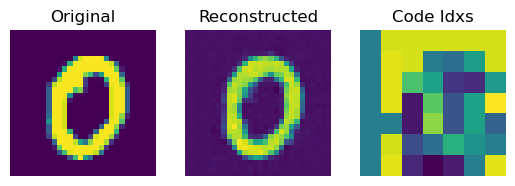

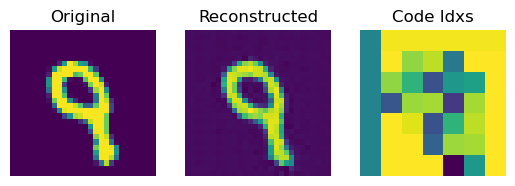

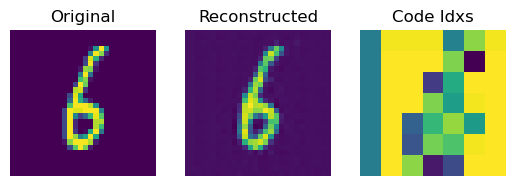

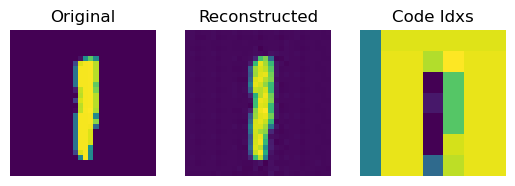

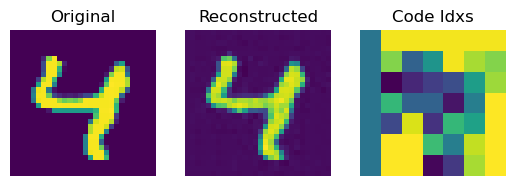

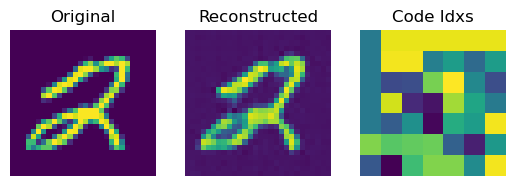

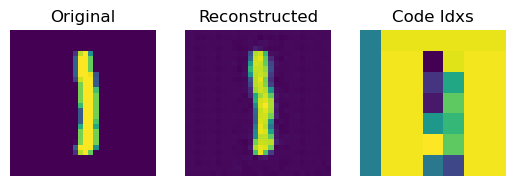

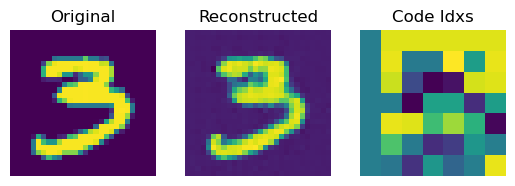

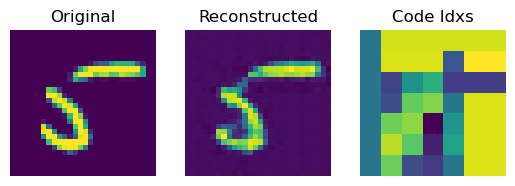

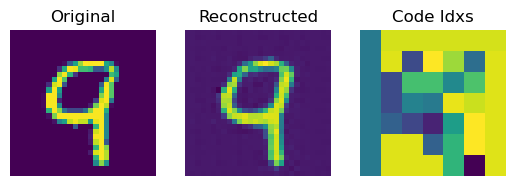

In [39]:
test(model=model_flavored, dataset=ds_test, device=device)

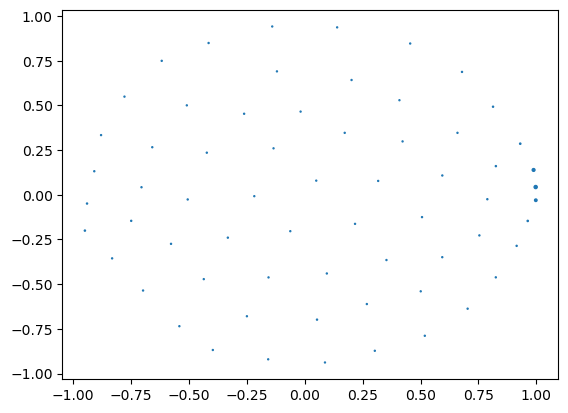

In [40]:
plot_codebook(codebook = model_flavored.vq.codebook.data.detach().cpu().numpy(),
              usage = model_flavored.vq.codebook_usage.detach().cpu().numpy())

Codebook usage stats: 0 tokens (0.0%) are never used in this codebook.


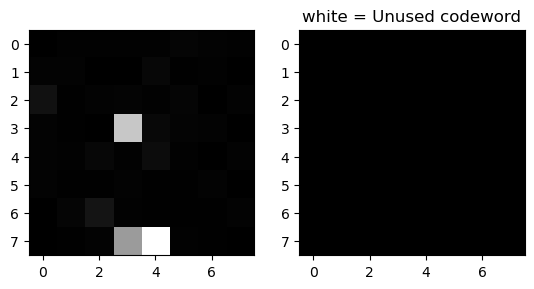

In [38]:
plot_codebook_usage(usage=model_flavored.vq.codebook_usage.detach().cpu().numpy())

# __Usage Analisys__

In [41]:
usage_raw = model.vq.codebook_usage.detach().cpu().numpy()
usage_flavored = model_flavored.vq.codebook_usage.detach().cpu().numpy()

min: 0.0011726384982466698
max: 0.22927115857601166
median: 0.006114199757575989
std: 0.03467973694205284
max used id: 56, 0.22927115857601166
min used id: 38, 0.0011726384982466698


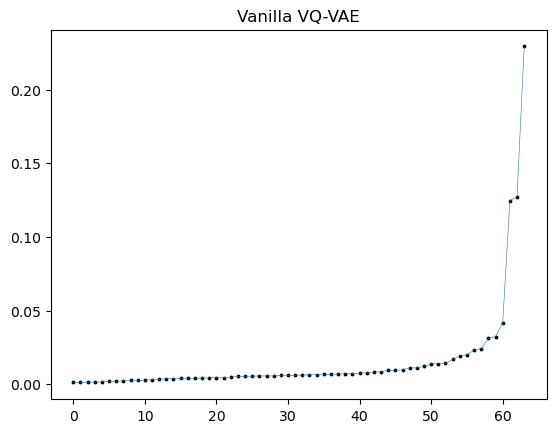

In [42]:
print_usage_stats(usage_raw, title='Vanilla VQ-VAE')

min: 0.004799249116331339
max: 0.2242569625377655
median: 0.006895209196954966
std: 0.037209782749414444
max used id: 60, 0.2242569625377655
min used id: 0, 0.004799249116331339


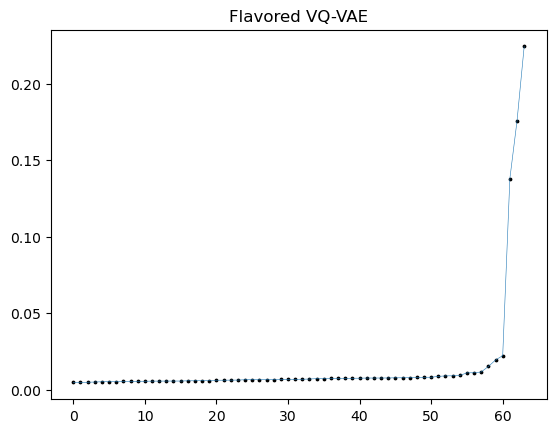

In [43]:
print_usage_stats(usage_flavored, title='Flavored VQ-VAE')